In [1]:
import pandas as pd
import numpy as np
import xml
import json
import requests
from bs4 import BeautifulSoup
!pip install folium
!pip install geocoder
#from geopy.geocoders import Nominatim
import geocoder
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

## Preparing Toronto data

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(url).text
soup = BeautifulSoup(source, 'xml')
table=soup.find('table')

df = pd.DataFrame(columns = ['Postalcode','Borough','Neighborhood'])

for tr_cell in table.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        df.loc[len(df)] = row_data
        
df.head(10)

,Postalcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
7,M8A,Not assigned,Not assigned
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"


In [3]:
df = df[df['Borough'] != 'Not assigned']
df.set_index(np.arange(df.shape[0]),inplace=True)

for line in range(df.shape[0]):
    if df.loc[line, 'Neighborhood'] == 'Not assigned':
        df.loc[line, 'Neighborhood'] = df.loc[line, 'Borough']
        
        
print(df.shape)
df

(103, 3)


,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [4]:
new_df=pd.read_csv('http://cocl.us/Geospatial_data')
new_df.rename(columns={'Postal Code':'Postalcode'},inplace=True)
new_df_merged = pd.merge(new_df, df, on='Postalcode')
new_data=new_df_merged[['Postalcode','Borough','Neighborhood','Latitude','Longitude']]
new_data.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Defining Toronto dataset

In [5]:
data_toronto=new_data[new_data['Borough'].str.contains("Toronto")]
data_toronto.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


## Preparing and defining New York data

In [6]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']



Data downloaded!


In [7]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

data_new_york = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    data_new_york = data_new_york.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
data_new_york.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


## Inserting my Foursquare credentials

In [8]:
CLIENT_ID = 'IMIYZAVIBA3W3VMNRQ11B1BAA0PL1P11H1HXF35TK4TEUFP3' # your Foursquare ID
CLIENT_SECRET = 'PPIJDHQCDRLXEKJOVJSGYSS0JELGWVKTMJL2RF1V0SDHUX3M' # your Foursquare Secret
VERSION = '20200116'

## Defining and using function 'getNearbyVenues'

In [9]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return nearby_venues

toronto_venues = getNearbyVenues(names=data_toronto['Neighborhood'],latitudes=data_toronto['Latitude'],longitudes=data_toronto['Longitude'])
newyork_venues = getNearbyVenues(names=data_new_york['Neighborhood'],latitudes=data_new_york['Latitude'], longitudes=data_new_york['Longitude'])
venues = pd.concat([newyork_venues, toronto_venues]).reset_index()
venues = venues.drop(['index'], axis=1)
venues

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West,  Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
...,...,...,...,...,...,...,...
11685,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,Amin Car Repair Garage,43.663544,-79.320130,Auto Workshop
11686,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,The Ashbridge Estate,43.664691,-79.321805,Garden
11687,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,Jonathan Ashbridge Park,43.664702,-79.319898,Park
11688,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,Olliffe On Queen,43.664503,-79.324768,Butcher


## Generating datasets

In [10]:
data_initial = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")
data_initial.drop(['Neighborhood'],axis=1,inplace=True) 
data_initial.insert(loc=0, column='Neighborhood', value=venues['Neighborhood'] )



total_dataset = data_initial.groupby('Neighborhood').mean().reset_index()

dataset = total_dataset.drop(['Neighborhood'], axis=1)
dataset

,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0
334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0
335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0
336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0


## Exploring data: showing most common venues

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

def showing_common_venues(dataset, num_top_venues=10):

    indicators = ['st', 'nd', 'rd']

    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    data_sorted = pd.DataFrame(columns=columns)
    data_sorted['Neighborhood'] = dataset['Neighborhood']

    for ind in np.arange(dataset.shape[0]):
        data_sorted.iloc[ind, 1:] = return_most_common_venues(dataset.iloc[ind, :], num_top_venues)
    return data_sorted

data_sorted = showing_common_venues(dataset=total_dataset)
data_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Chinese Restaurant,Deli / Bodega,Supermarket,Check Cashing Service,Martial Arts School,Grocery Store,Mexican Restaurant,Gas Station,Donut Shop
1,Annadale,Bakery,American Restaurant,Pizza Place,Pharmacy,Train Station,Park,Diner,Restaurant,Liquor Store,Cosmetics Shop
2,Arden Heights,Pizza Place,Pharmacy,Lawyer,Coffee Shop,Bus Stop,Yoga Studio,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service
3,Arlington,Bus Stop,Boat or Ferry,American Restaurant,Deli / Bodega,Intersection,Food & Drink Shop,Farm,English Restaurant,Entertainment Service,Escape Room
4,Arrochar,Pizza Place,Bus Stop,Italian Restaurant,Deli / Bodega,Cosmetics Shop,Food Truck,Supermarket,Middle Eastern Restaurant,Outdoors & Recreation,Mediterranean Restaurant


## Defining optimum number of clusters and generating them

In [12]:
from sklearn.cluster import KMeans
def calculate_wcss(data):
    wcss = []
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2


In [46]:
nclusters = optimal_number_of_clusters(calculate_wcss(dataset))

kmeans_cluster = KMeans(n_clusters = nclusters, random_state=0).fit(dataset)

labels = kmeans_cluster.labels_
nclusters

8

## Preparing for plotting maps

In [14]:
end_data = venues[['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude']].drop_duplicates('Neighborhood').reset_index()
end_data['Label'] = labels
end_data


,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Label
0,0,Wakefield,40.894705,-73.847201,5
1,9,Co-op City,40.874294,-73.829939,5
2,26,Eastchester,40.887556,-73.827806,5
3,48,Fieldston,40.895437,-73.905643,4
4,51,Riverdale,40.890834,-73.912585,5
...,...,...,...,...,...
333,11571,"High Park, The Junction South",43.661608,-79.464763,5
334,11595,"Parkdale, Roncesvalles",43.648960,-79.456325,5
335,11609,"Runnymede, Swansea",43.651571,-79.484450,5
336,11642,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2


## Interpreting the clusters - Showing the 10 most frequent venues

In [248]:
import matplotlib.pyplot as plt

df_list = [np.nan]*len(labels)
total_dataset['Label'] = labels 
for label in np.arange(len(labels)):
    df_list[label] = total_dataset[total_dataset['Label'] == label].drop('Label', axis=1, inplace=False)
    
def counting_venues(cluster_common_venues):
    count = pd.Series(dtype='float64')
    columns = list(cluster_common_venues.columns)
    try:
        columns.remove('index')
    except:
        pass
    for column_name in columns:
        count = pd.concat([count, cluster_common_venues[column_name].value_counts()])
    return count.groupby(level=0).sum()

def plotting_bars(dataframe_cluster, figsize=(20,8), width=0.8, fontsize=16):
    cluster = showing_common_venues(dataset=dataframe_cluster)
    count = counting_venues(cluster)
    count = count/(count.sum())*100
    count = count.nlargest(10)
    ax = count.plot(kind='bar', figsize=figsize, width=width, fontsize=fontsize)
    plt.title("10 most common Venues around the cluster (percentage)",fontsize=fontsize)
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate('{:.2%}'.format(height/100), (x, y + height + 0.01), fontsize=fontsize)
    plt.show()

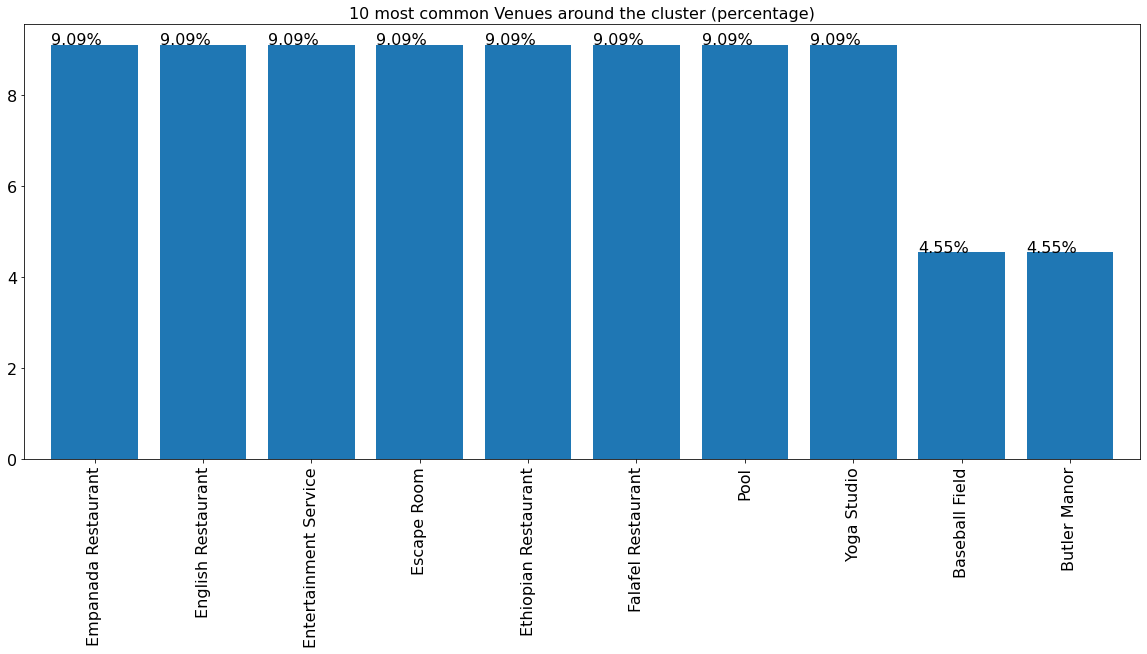

In [249]:
plotting_bars(df_list[0])

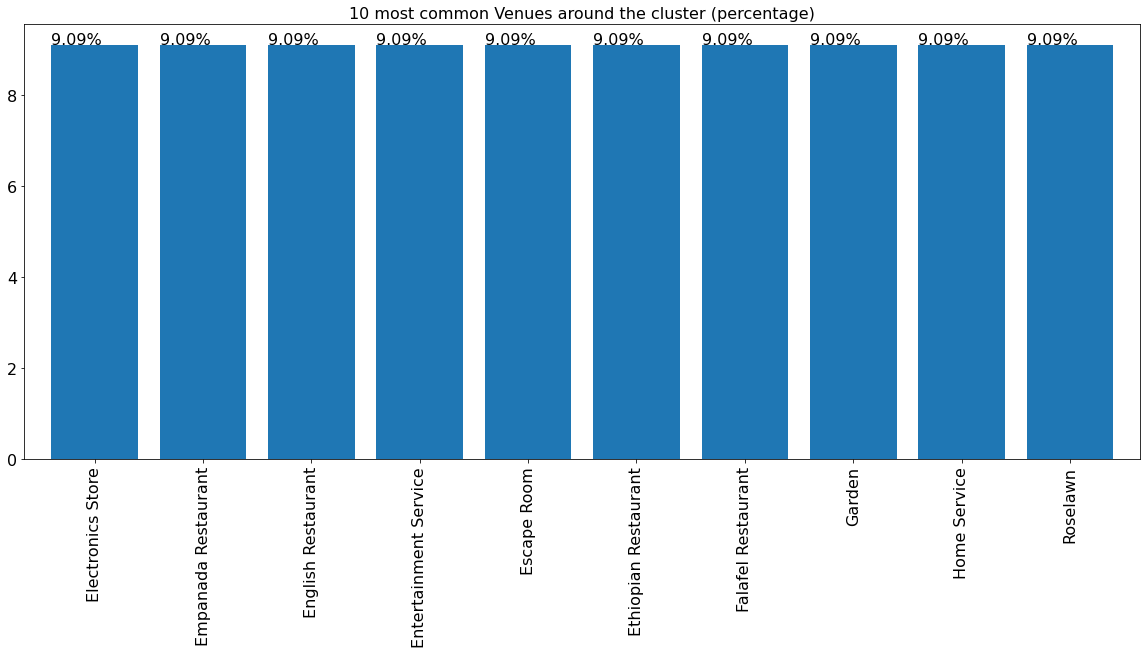

In [250]:
plotting_bars(df_list[1])

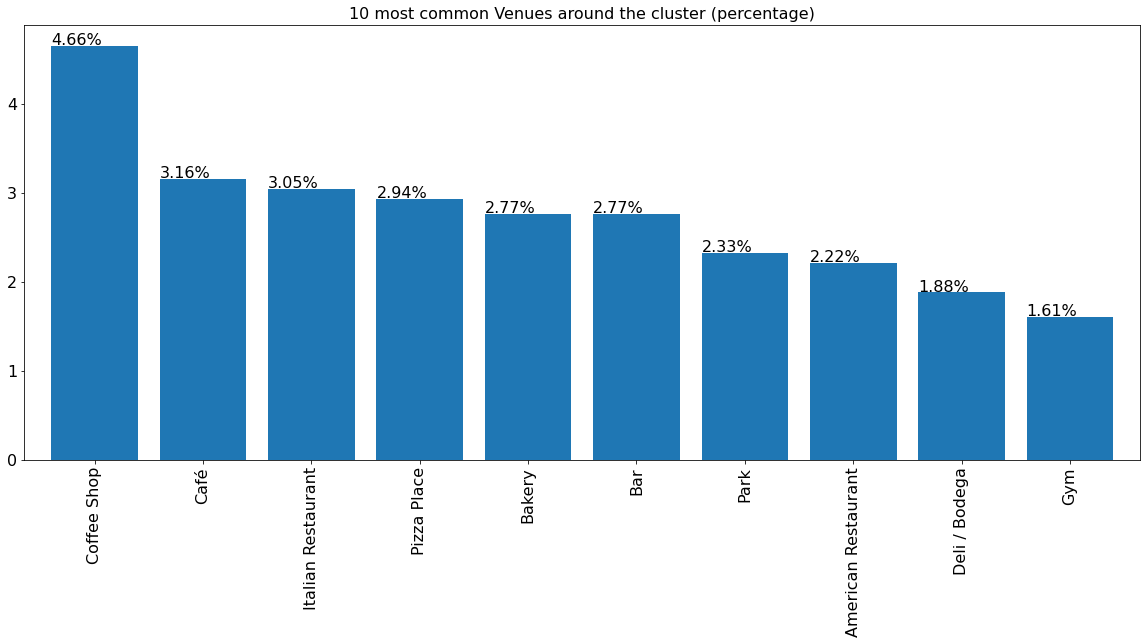

In [251]:
plotting_bars(df_list[2])

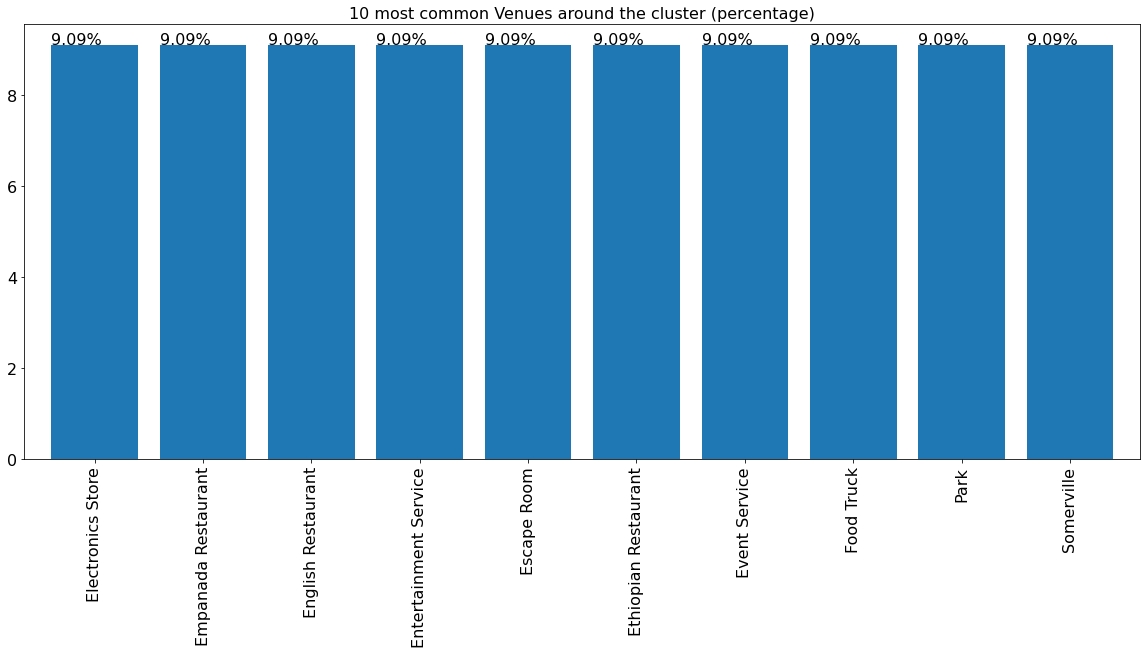

In [252]:
plotting_bars(df_list[3])

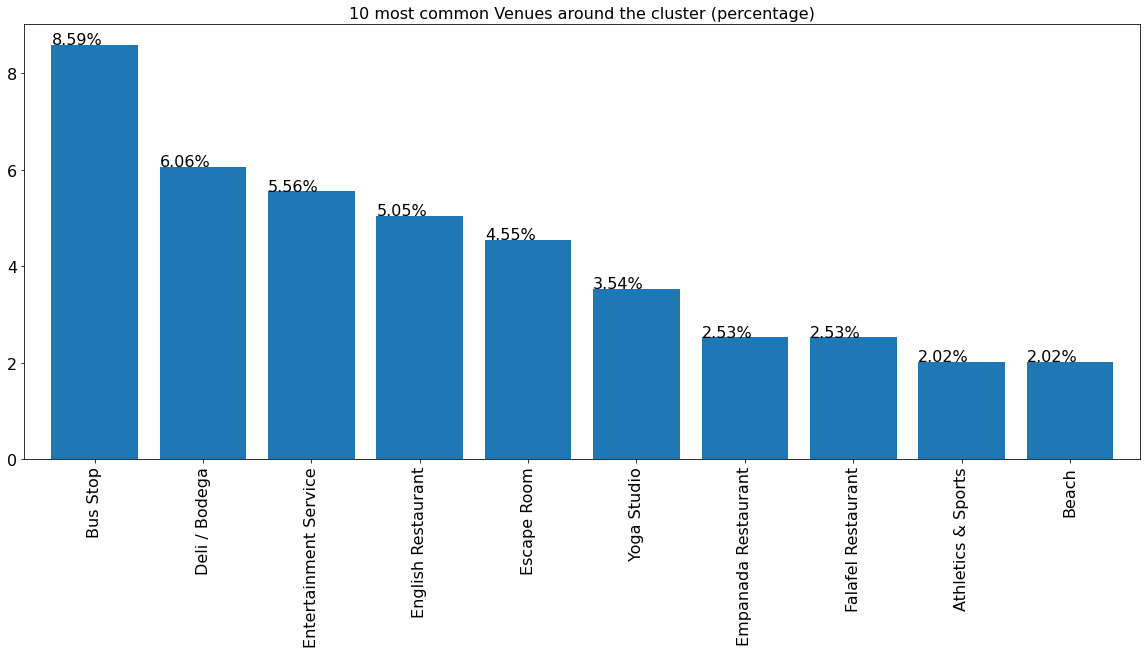

In [253]:
plotting_bars(df_list[4])

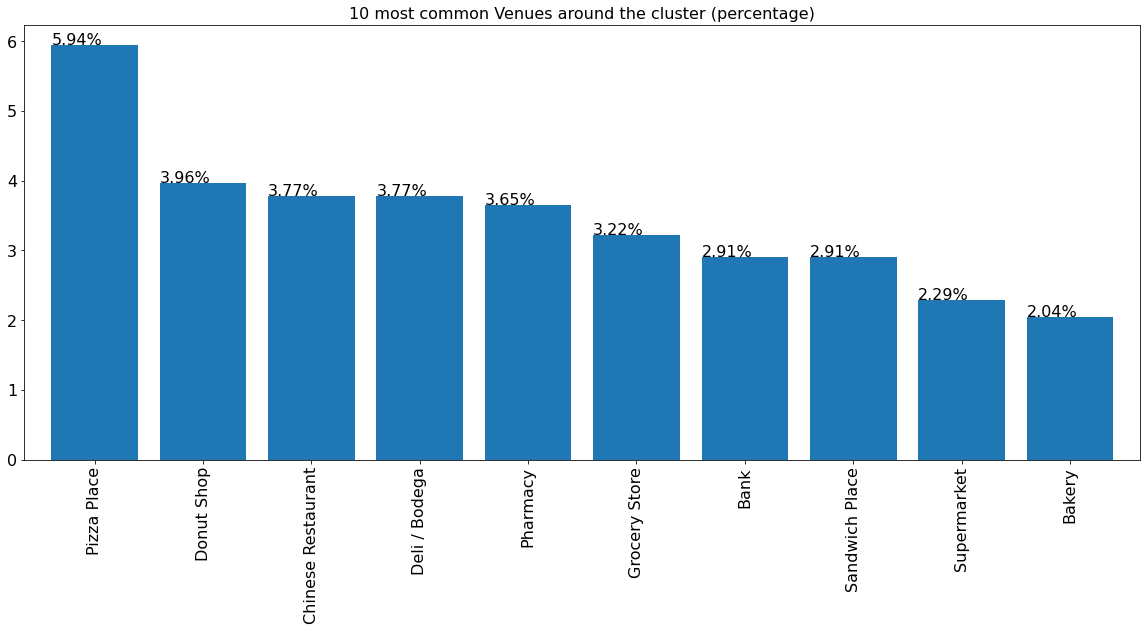

In [254]:
plotting_bars(df_list[5])

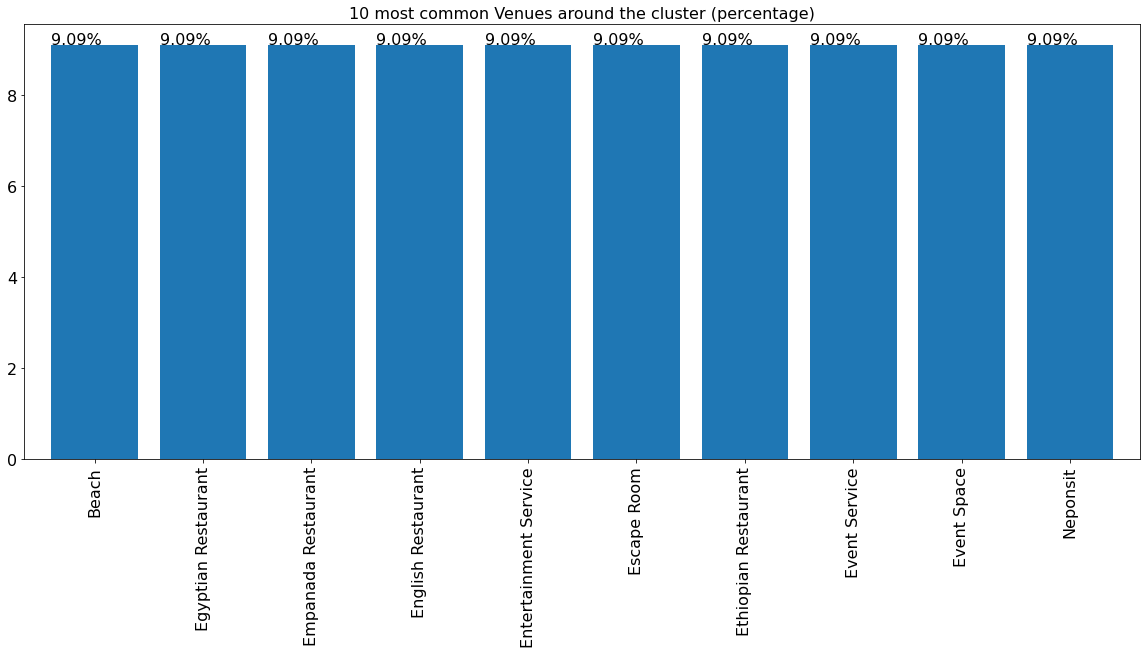

In [255]:
plotting_bars(df_list[6])

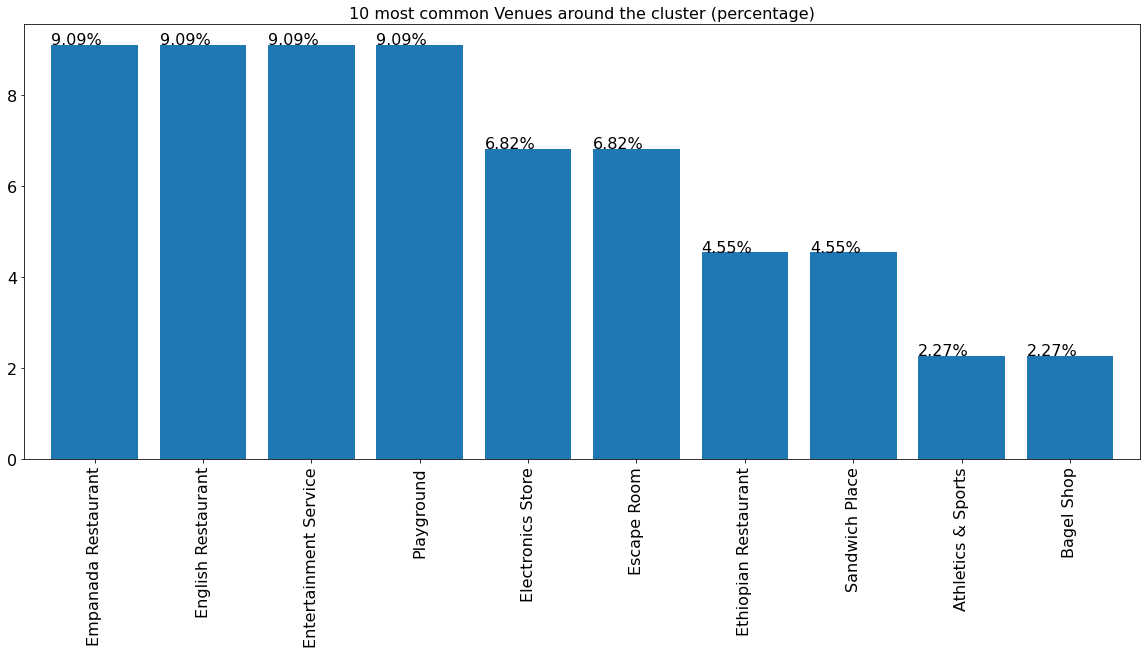

In [256]:
plotting_bars(df_list[7])

## Plotting Maps

In [208]:
map_clusters_toronto = folium.Map(location=[43.653963, -79.387207], zoom_start=11)
map_clusters_ny = folium.Map(location=[40.887556, -73.827806], zoom_start=10)

# set color scheme for the clusters
x = np.arange(nclusters)
ys = [i + x + (i*x)**2 for i in range(nclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(end_data['Neighborhood Latitude'], end_data['Neighborhood Longitude'], end_data['Neighborhood'], end_data['Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_toronto)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_ny)

In [206]:
map_clusters_toronto

In [209]:
map_clusters_ny